# Bag the Models with Bagging

The **combination of classifiers can help reduce misclassification errors substantially**. Many studies have proved such ensembling methods can **significantly reduce the variance of the prediction model**. Several techniques have been proposed to achieve a variance reduction. For example, in many cases, bootstrap aggregating (bagging) classification trees have been shown to have higher accuracy than a single classification tree. **Bagging can be applied to tree-based algorithms to enhance the accuracy of the predictions**, although it can be used with methods other than tree-based methods as well.

## Bootstrap aggregation

**Bootstrap aggregation**, also known as **bagging**, is a powerful ensemble method that was proposed by Leo Breiman in 1994 **to prevent overfitting**. **The concept behind *bagging* is to combine the predictions of several base learners to create a more accurate output.**

Breiman showed that **bagging can successfully achieve the desired result in unstable learning algorithms where small changes to the training data can lead to large variations in the predictions**. Breiman demonstrated that algorithms such as neural networks and decision trees are examples of unstable learning algorithms. Bootstrap aggregation is effective on small datasets.

The general procedure for bagging helps to reduce variance for those algorithms have high variance. Bagging also supports the classification and regression problem. The following diagram shows how the bootstrap aggregation flow works:
![Alt text](bagging.png)

Using bootstrapping with a training dataset X, we generate N bootstrap samples X1, X2,....., XN.

For each bootstrap sample, we train a classifier, $b_i(x)$. The combined classifier will average the outputs from all these individual classifiers as follows:

$$
b(x) = \frac{1}{N}\sum^N_{i=1}b_i(x)
$$

In the preceding formula, $N$ represents the number of samples.

In a **bagging classifier**, **voting is used to make a final prediction**. The pseudo-code for the bagging classifier proposed by Breiman is as follows:

![Diagram showing the bagging classifier process. Multiple base classifiers are trained on different bootstrap samples of the data. Each classifier makes a prediction, and the final output is determined by majority voting among all classifiers. The diagram includes arrows from each classifier to a voting box, which then points to the final prediction. The text in the image reads: For i = 1 to N: Draw a bootstrap sample from the training set, train a classifier on the sample, and store the classifier. To make a prediction, aggregate the predictions of all classifiers by majority vote.](bagging_classifier.png)

In the case of the **bagging regressor**, **the final prediction is the average of the predictions of the models that are built over each bootstrap sample**. The following pseudo-code describes the bagging regressor:

![Diagram illustrating the bagging regressor process. Several base regressors are trained on different bootstrap samples of the data. Each regressor outputs a prediction, and the final output is the average of all predictions. The diagram shows arrows from each regressor to an averaging box, which then points to the final prediction. The text in the image reads: For i = 1 to N: Draw a bootstrap sample from the training set, train a regressor on the sample, and store the regressor. To make a prediction, average the predictions of all regressors.](bagging_regressor.png)

### Getting ready

We start by importing the required libraries and reading our file. We suppress any warnings using the `warnings.filterwarnings()` function from the `warnings` library

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

import matplotlib.pyplot as plt

df_autodata = pd.read_csv("autompg.csv")

# We check wether the dataset has any missing values as follows
# the below syntax returns the columns names which has any missing value
columns_with_missing_values = df_autodata.columns[df_autodata.isnull().any()]

# We pass the column names with missing values to the dataframe to count the number
# of missing values
df_autodata[columns_with_missing_values].isnull().sum()

horsepower    6
dtype: int64

In [4]:
# We notice that the horsepower variable has six missing values. We can fill in the missing values using the median of the horsepower variable's existing values with the following code:
df_autodata['horsepower'].fillna(df_autodata['horsepower'].median(), inplace=True)
# We notice that the carname variable is an identifier and is not useful in our model-building exercise, so we can drop it as follows:

df_autodata.drop(['carname'], axis=1, inplace=True)
# We can look at the data with the dataframe.head() command:

df_autodata.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


### How to do it

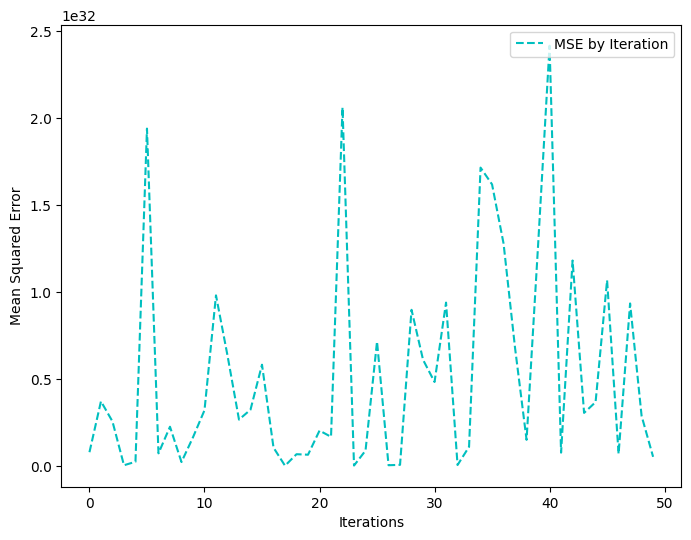

In [5]:
# 1 We start by creating the bootstrap samples
# In Chapter 3, Resampling Methods, we wrote a
# custom function, create_bootstrap_oob(), to
# create both bootstrap and out-of-bag (OOB) samples.

def create_bootstrap_oob(df):
    global df_OOB
    global df_bootstrap_sample 
    # creating the bootstrap sample
    df_bootstrap_sample = resample(df, replace=True, n_samples=100)
    
    # creating the OOB sample 
    bootstrap_sample_index = tuple(df_bootstrap_sample.index)
    bootstrap_df = df.index.isin(bootstrap_sample_index)
    
    df_OOB = df[~bootstrap_df]

# 2 We build models using the bootstrap samples and average
# the cost function across all the models. We use the SGDRegressor()
# on each bootstrap sample. In the following code block, we reuse
# our previously written custom function, create_bootstrap_oob(),
# to create the bootstrap and OOB error samples:
iteration=50
mse_each_iterations = list()
lm=SGDRegressor()
total_mse=0
average_mse= list()

for i in range(iteration):
    create_bootstrap_oob(df_autodata)

    # Bootstrap sample features set
    X_BS = df_bootstrap_sample.iloc[:,1:8] 

    # bootstrap sample response variable
    Y_BS = df_bootstrap_sample.iloc[:,0]
    X_OOB = df_OOB.iloc[:,1:8] #OOB sample features
    Y_OOB = df_OOB.iloc[:,0] #OOB sample response variable 
    
    # fit your model with bootstrap sample
    lm=SGDRegressor()
    lm.fit(X_BS, Y_BS)
    
    # test your model on out-of-bag sample 
    predictedvalues = lm.predict(X_OOB)
    
    # capture MSE for the predicted values against OOB actuals
    mse = mean_squared_error(Y_OOB, predictedvalues)
    
    # create a list of mse values
    mse_each_iterations.append(mse)

# 3 We are now going to plot the MSE for each model built:
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize=(8,6))

plt.plot(mse_each_iterations, 'c--', label='MSE by Iteration')

plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend(loc=1)
plt.show()

### How it works

In Step 1, we executed our custom function code to create the `create_bootstrap_oob()` function that creates the bootstrap and `OOB samples` for us. In Step 2, we executed the following steps:

1. We decided to make $50$ iterations, so we set the iteration variable to 50.
2. The `create_bootstrap_oob()` function returned two DataFrame objects, df_bootstrap_sample and df_OOB, in each iteration.
3. We used `df_bootstrap_sample` and `df_OOB` as our bootstrap and OOB samples respectively.
4. We split both the df_bootstrap_sample and the `df_OOB` samples into feature sets and response variables.
5. We fit the `SGDRegressor()` to our bootstrap sample to build our model.
6. We passed the `OOB sample` to the model to predict our values.
7. We compared the predicted values against the response variable in the OOB sample.
8. We calculated the `MSE` for each iteration.

In Step 3, we created a plot to show the MSE for each iteration up to the fiftieth iteration. This result may vary because of randomness.

## Ensemble meta-estimators

The **bagging classifier and the bagging regressor are ensemble meta-estimators** that **fit the base classifier and regressor models respectively on random subsets of the original dataset**. The **predictions from each model are combined to create the final prediction**. These kinds of meta-estimators induce randomization into the model-building process and aggregate the outcome. **The aggregation averages over the iterations for a numerical target variable and performs a plurality vote in order to reach a categorical outcome**.

## Bagging classifiers

Bagging classifiers train each classifier model on a random subset of the original training set and aggregate the predictions, then perform a plurality voting for a categorical outcome. In the following recipe, we are going to look at an implementation of a bagging classifier with bootstrap samples.

### How to do it

In [6]:
# 1 We import BaggingClassifier and DecisionTreeClassifier from
# scikit-learn
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# 2 Next we read out the data and take a look at the dim
df_winedata = pd.read_csv('./winedata.csv')
df_winedata.shape

(177, 14)

In [7]:
# 3 We separate our features and the response set. We also split
# out data into train test subsets
X = df_winedata.iloc[:, 1: 14]
y = df_winedata.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# 4 We create an instance of the DecisionTreeClassifier class and pass
# it to the BagginClassifier()
dt_model = DecisionTreeClassifier(criterion='entropy')
bag_dt_model = BaggingClassifier(dt_model, max_features=1.0, n_estimators=5, \
                            random_state=1, bootstrap=True)

# Note that in the preceding code block, we have declared bootstrap=True. 
# This is the default value and indicates that samples are drawn with replacement.

# 5 We fit our model to the training data as follows
bag_dt_model.fit(X_train, y_train)

# 6 We can see the score after passing the test data to the model
bag_dt_model.score(X_test, y_test)

# 7 We use the predict function to predict the response variable as follows
predictedvalues = bag_dt_model.predict(X_test)

In [8]:
# 8 e will now use a code to plot the confusion matrix. Note that this code has been taken from scikit-learn.org. We execute the following code to create the plot_confusion_matrix() function:
# code from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actuals')
    plt.xlabel('Predicted')

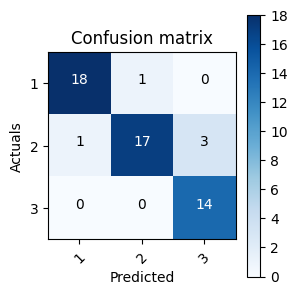

In [9]:
# 9 We use the preceding plot_confusion_matrix() function to plot our confusion matrix:
# This variable holds the class labels of our target variable
target_names = [ '1', '2', '3']

import itertools
from sklearn.metrics import confusion_matrix

# Constructing the Confusion Matrix
cm = confusion_matrix(y_test, predictedvalues)
# Plotting the confusion matrix
plt.figure(figsize=(3,3))
plot_confusion_matrix(cm, classes=target_names, normalize=False)
plt.show()

### How it works

In Step 1, we imported the required libraries to build our decision tree classifier model using the bagging classifier. In Step 2, we read our dataset, which was winedata.csv. In Step 3, we separated our feature set and the target variable. We also split our data into training and testing subsets. In Step 4, we created a decision tree classifier model and passed it to the `BaggingClassifier()`. In the `DecisionTreeClassifier()`, the default value for the criterion parameter was gini, but we changed it to entropy. We then passed our decision tree model to the `BaggingClassfier()`. In the `BaggingClassfier()`, we have parameters including n_estimators and bootstrap. n_estimators is the number of base estimators in the ensemble and has a default value of 10. The bootstrap parameter indicates whether samples are drawn with replacement or not and is set to True by default.

In Step 5 and Step 6, we fitted our model to the training data and looked at the score of the test set. In Step 7, we called the `predict()` method and passed the test feature set. In Step 8, we added the code for the `plot_confusion_matrix()` from http://scikit-learn.org, which takes the confusion matrix as one of its input parameters and plots the confusion matrix. In Step 9, we called the `plot_confusion_matrix()` function by passing the confusion matrix to generate the confusion matrix plot.

### There's more

We can also use `GridSearchCV()` from sklearn.model_selection to grid search the best parameters and use them in the `BaggingClassifier`:

In [10]:
# NOTE:  In newer versions of scikit-learn, the way parameters are specified for nested estimators has been updated.
# Specifically, when using GridSearchCV with a BaggingClassifier, you should use the estimator__ prefix instead of
# base_estimator__ to specify parameters for the underlying estimator.

In [11]:
# 1 First we import the required libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# 2 We then set our parameter values
# param_values = {'n_estimators': [10, 20, 25, 30], 'base_estimator__max_leaf_nodes':[5, 10, 15, 20], 'base_estimator__max_depth':[3, 4, 5]}
param_values = {
    'n_estimators': [10, 20, 25, 30],
    'estimator__max_leaf_nodes': [5, 10, 15, 20],
    'estimator__max_depth': [3, 4, 5]
}
# 3 We instantiate our DecisionTreeClassifier class and pass it to the BaggingClassifier() function.
# Note that we set the oob_score to True to evaluate the models built on the OOB samples:
dt_model = DecisionTreeClassifier()
bag_dt_model_grid = BaggingClassifier(estimator=dt_model, oob_score=True, random_state=1)
# 4 We use GridSearchCV() to determine the best parameters:
bc_grid = GridSearchCV(estimator=bag_dt_model_grid, param_grid=param_values, cv=20, n_jobs=-1)
bc_grid.fit(X_train, y_train)
best_params = bc_grid.best_params_
print(best_params)

{'estimator__max_depth': 3, 'estimator__max_leaf_nodes': 5, 'n_estimators': 30}


In [12]:
# 5 We now take the values returned by bc_grid.bestparams and rebuild our decision tree models using the BaggingClassfier() function. We pass 10 for the max_leaf_nodes, 3 for the max_depth, and 20 for the n_estimators:
best_dt_model = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10, max_depth=3) 
final_bag_dt_model = BaggingClassifier(estimator=best_dt_model, n_estimators=150, bootstrap=True, random_state=1, oob_score=True)
# We set our n_estimators to 150 in the preceding code block. The n_estimators parameter
# indicates the number of trees we want to build. We fit our final model to our training
# data and make a prediction using our test feature set.

# 6 We can then look at the accuracy of our OOB samples in the following code block:
final_bag_dt_model.fit(X_train, y_train)
bag_predictedvalues = final_bag_dt_model.predict(X_test)

# See the OOB accuracy
acc_oob = final_bag_dt_model.oob_score_
print(acc_oob)
# If we plot our confusion matrix, we can see that we have made an improvement with regard to the number of misclassifications
# that are made. In the earlier example, two instances of class 2 were wrongly predicted as class 3, but we can now see that
# the number of misclassifications has reduced to one:

0.9512195121951219


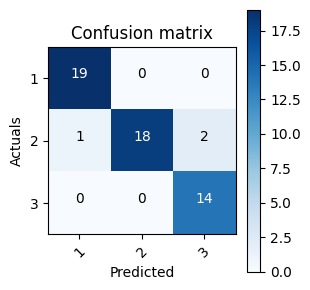

In [13]:
# Plot the confusion matrix
plt.figure(figsize=(3,3))
plot_confusion_matrix(confusion_matrix(y_test, bag_predictedvalues), classes=target_names, normalize=False)
plt.show()

## Bagging regressors

Bagging regressors are similar to bagging classifiers. They train each regressor model on a random subset of the original training set and aggregate the predictions. Then, the aggregation averages over the iterations because the target variable is numeric. In the following recipe, we are going to showcase the implementation of a bagging regressor with bootstrap samples.

### Getting ready

In [16]:
# We will import the required libraries, `BaggingRegressor` and `DecisionTreeRegressor`, from `sklearn.ensemble` and `sklearn.tree` respectively:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# We read our dataset, which is bostonhousing.csv, and look at the dimensions of the DataFrame:
df_housingdata = pd.read_csv('BostonHousing.csv')
df_housingdata.shape

(506, 14)

We now move on to creating our feature set and our target variable set.

### How to do it

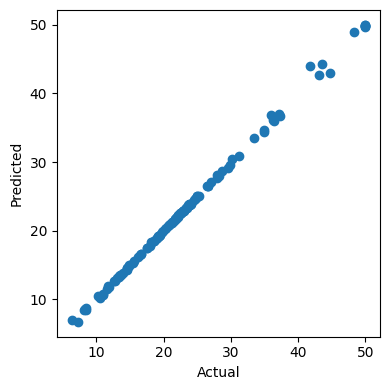

In [17]:
# 1 We first separate our feature and response set. We will also split our data into training and testing subsets in the following code block:
X = df_housingdata.iloc[:,1:14]
y = df_housingdata.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# 2 We will then create an instance of the DecisionTreeRegressor class and pass it to the BaggingRegressor() function:
dt_model    = DecisionTreeRegressor()
bag_dt_model = BaggingRegressor(dt_model, max_features=1.0, n_estimators=5, bootstrap=True, random_state=1, )
# 3 We will fit our model to the training dataset as follows:
bag_dt_model.fit(X_train, y_train)

# 4 We can see the model score in the following code block:
bag_dt_model.score(X_test, y_test)
# 5 We use the predict() function and pass the test dataset to predict our target variable as follows:
predictedvalues = bag_dt_model.predict(X_test)
# 6 We plot the scatter plot of our actual values and the predicted values of our target variable with the following code:
#We can plot the actuals and the predicted values 
plt.figure(figsize=(4, 4))
plt.scatter(y_test, predictedvalues)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
# Executing the preceding code gives us the following scatter plot:

The `matplotlib.pyplot.tight_layout()` **automatically adjusts the subplot parameters to create specified padding**. This is useful when we have multiple subplots and want to ensure that they do not overlap or have excessive whitespace between them.

In [ ]:
# 7 We now change the n_estimators parameter to 30 in the following code and re-execute the steps from Step 3 to Step 6:
bag_dt_model = BaggingRegressor(dt_model, max_features=1.0, n_estimators=30, bootstrap=True, random_state=1, )
# This gives us the following score at the end of the code block:
bag_dt_model.fit(X_train, y_train)
# We can see the model score in the following code block:
print(bag_dt_model.score(X_test, y_test))

0.9994660497071766


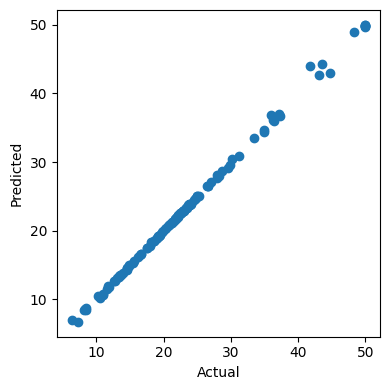

In [21]:
# 8 The plot of the actual values against the predicted values looks as follows. This shows us that the values are predicted
# more accurately than in our previous case when we changed the value of the n_estimator parameter from 5 to 30:
plt.figure(figsize=(4, 4))
plt.scatter(y_test, predictedvalues)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
# Executing the preceding code gives us the following scatter plot:
plt.show()

### How it works

In Step 1, we separated the features and the target variable set. We also split our data into training and testing subsets. In Step 2, we created a decision tree regressor model and passed it to the `BaggingRegressor()` function. Note that we also passed the `n_estimator=5` parameter to the `BaggingRegressor()` function. As mentioned earlier, n_estimator is the number of trees in the forest we would like the algorithm to build. In Step 3, we trained our model.

In Step 4, we looked at the model score, which was $0.71$. In Step 5, we used the `predict()` function to predict our target variable for the test subset. After that, in Step 6, we plotted a scatterplot to explore the relationship between the actual target values and the predicted target values.

In Step 7, we changed the `n_estimator` parameter's value from 5 to 30 and re-built our model. This time, we noticed that the model score improved to $0.82$. In Step 8, we plotted the actual and predicted values and saw that the correlation between the actual and predicted values was much better than our previous model, where we used `n_estimators=5`.